In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath('../'))
import fastnc

## Bispectrum class

In [3]:
# Instantiate bispectrum class
bs = fastnc.bispectrum.BispectrumNFW1Halo()

In [4]:
# Compute matter bispectrum
# Note: for this toy model bispectrum class, we did not implement matter power spectrum.
# k = np.logspace(-3, 1, 1000)
# z = np.zeros_like(k)
# bk= bs.matter_bispectrum(k,k,k,z)


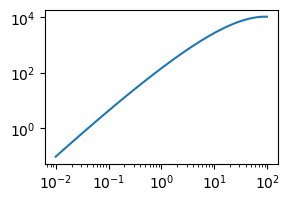

In [5]:
# Compute kappa bispectrum directly
l = np.logspace(-2, 2, 100)
bl= bs.kappa_bispectrum(l,l,l, method='direct')
plt.figure(figsize=(3,2))
plt.loglog(l, l**2*bl);

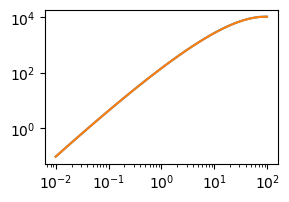

In [6]:
# Interpolation call of kappa bispectrum
bs.interpolate(nrbin=50, nubin=50, nvbin=50)
bli= bs.kappa_bispectrum(l,l,l, method='interp')
plt.figure(figsize=(3,2))
plt.loglog(l, l**2*bl)
plt.loglog(l, l**2*bli);

[multipole]: 100%|██████████| 16/16 [00:00<00:00, 19.11it/s, L=15]


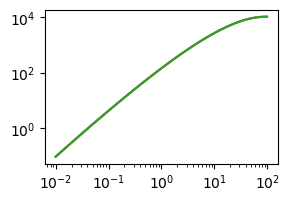

In [7]:
# decompose into multipoles up to a specified maximum multipole, Lmax.
bs.decompose(15, method_bispec='interp')
blr= bs.kappa_bispectrum(l,l,l, method='resum')
plt.figure(figsize=(3,2))
plt.loglog(l, l**2*bl)
plt.loglog(l, l**2*bli)
plt.loglog(l, l**2*blr);

# Fastnc class: Fast Natural Component

In [8]:
# Instantiate fast natural components class with Lmax=15, Lmin=30
# This can be slow for the first time to create GLM cache.
nc = fastnc.fastnc.FastNaturalComponents(25, 40)

Load GLMdata from cache: GLMdata-2.pkl


[GLM]: 100%|██████████| 1066/1066 [00:01<00:00, 548.03it/s, L=25, M=40]


In [9]:
# Set bispectrum
# Note: you need to interpolate bispectrum before setting it to fastnc
# Note: you *do not* have to decompose bispectrum, fastnc calls `decompose` internally.
nc.set_bispectrum(bs)

[multipole]: 100%|██████████| 26/26 [00:01<00:00, 19.89it/s, L=25]


In [10]:
# compute multipole of natural component, 
# for a given natural component index=0, i.e. prep. for Gamma^{(0)}.
# If you want to compute components 1,2, or 3 as well, 
# input the list of indices, e.g. [0,1,2,3]
nc.update(0)

[GammaM]: 100%|██████████| 41/41 [00:04<00:00,  8.85it/s, M=40]


CPU times: user 8.88 ms, sys: 1.6 ms, total: 10.5 ms
Wall time: 9.54 ms


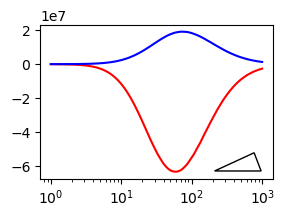

In [11]:
# Compute Gamma^{(0)} with x-projection with treecorr convention
t = np.logspace(0, 3, 100) # arcmin
r = np.deg2rad(t/60.0) # rad
u = 0.45
v = 0.15
%time g0 = nc.Gamma0_treecorr(r, u, v)
fig, ax = plt.subplots(1,1,figsize=(3,2))
ax.semilogx(t, t*g0.real, color='red' , label='real')
ax.semilogx(t, t*g0.imag, color='blue', label='imag');
x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
fastnc.devtool.plot_triangle(ax, x1,x2,x3)

CPU times: user 7.1 ms, sys: 1.46 ms, total: 8.57 ms
Wall time: 7.46 ms


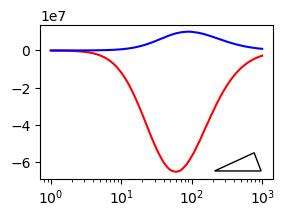

In [12]:
# Same but centroid-projection
t = np.logspace(0, 3, 100) # arcmin
r = np.deg2rad(t/60.0) # rad
u = 0.45
v = 0.15
%time g0 = nc.Gamma0_treecorr(r, u, v, projection='cent')
fig, ax = plt.subplots(1,1,figsize=(3,2))
ax.semilogx(t, t*g0.real, color='red' , label='real')
ax.semilogx(t, t*g0.imag, color='blue', label='imag');
x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
fastnc.devtool.plot_triangle(ax, x1,x2,x3)

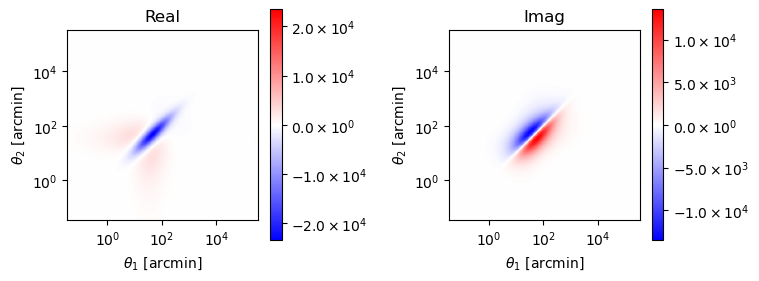

In [13]:
# plot the structure of natural component Gamma^{(0)} in two dimensional space 
# with a fixed outer angle, dvphi between t1 and t2
# This is plotting Gamma^{(0)}(t1, t2, dvphi)(t1t2)^{1/2} on (t1, t2) grids.
dvphi = np.pi/3
g0 = nc.Gamma0(dvphi)
t1, t2 = nc.t1, nc.t2
fig, ax = fastnc.devtool.imshow_g0(t1, t2, g0)

# Speed of fastnc

In [14]:
# define bin
t = np.logspace(0, 3, 100) # arcmin
r = np.deg2rad(t/60.0) # rad
ubins = [0.16, 0.35, 0.55, 0.75, 0.95]
vbins = [0.15, 0.35, 0.55, 0.75, 0.97]

In [15]:
# Measure the time of fastnc computation
# which is done every mcmc step.
sw = fastnc.devtool.StopWatch()

bs.interpolate(nrbin=50, nubin=50, nvbin=50); sw('interp')
nc.set_bispectrum(bs); sw('multipole')
nc.update(0); sw('kernel')

g0 = [[0 for _ in range(5)] for _ in range(5)]
for i, u in enumerate(ubins):
    for j, v in enumerate(vbins):
        g0[i][j] = nc.Gamma0_treecorr(r, u, v, projection='cent')
sw('Gamma0')
sw.close()

interp: 0.026s


[multipole]: 100%|██████████| 26/26 [00:01<00:00, 15.77it/s, L=25]


multipole: 2.183s


[GammaM]: 100%|██████████| 41/41 [00:04<00:00,  9.22it/s, M=40]


kernel: 4.457s
Gamma0: 0.253s
Total: 6.920s


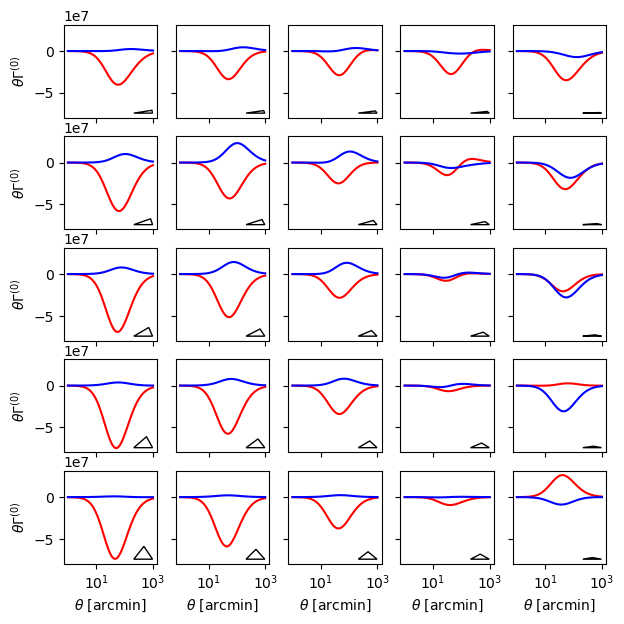

In [16]:
fig, axes = plt.subplots(5,5,figsize=(7,7), sharex=True, sharey=True)
for i, u in enumerate(ubins):
    for j, v in enumerate(vbins):
        ax = axes[i,j]
        ax.set_xscale('log')
        ax.semilogx(t, t*g0[i][j].real, color='red')
        ax.semilogx(t, t*g0[i][j].imag, color='blue')
        x1,x2,x3=fastnc.trigutils.ruv_to_x1x2x3(1,u,v)
        fastnc.devtool.plot_triangle(ax,x1,x2,x3)
        ax.set_xlabel(r'$\theta$ [arcmin]') if i==4 else None
        ax.set_ylabel(r'$\theta\Gamma^{(0)}$') if j==0 else None
plt.show()